In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import lightgbm as lgb
import seaborn as sns

In [5]:
df = pd.read_csv('/Users/estyle-150/github/my_signage/data/processed/processed20240826_2.csv')
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)

# 訓練データをとる
train_data = df[df['is_train'] == 1].copy()

# テストデータをとる
test_data = df[df['is_train'] == 0].copy()

# 訓練データから不要な列（'is_train'）を削除
train_data.drop(['is_train'], axis=1, inplace=True)

# テストデータから不要な列を削除
test_data.drop(['y','is_train'], axis=1, inplace=True)

display(train_data.head(), test_data.head())


,y,client,close,price_am,price_pm,price,y_lag_365,price_am_lag_1,price_am_lag_7,price_am_lag_365,price_pm_lag_1,price_pm_lag_7,price_pm_lag_365,price_am_moving_avg_7,price_am_moving_avg_30,price_pm_moving_avg_7,price_pm_moving_avg_30
datetime,,,,,,,,,,,,,,,,,
2011-01-04,16,0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-05,16,0,0,0.0,0.0,0.0,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-06,13,0,0,0.0,0.0,0.0,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-07,14,0,0,0.0,0.0,0.0,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-08,16,0,0,0.0,0.0,0.0,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN


,client,close,price_am,price_pm,price,y_lag_365,price_am_lag_1,price_am_lag_7,price_am_lag_365,price_pm_lag_1,price_pm_lag_7,price_pm_lag_365,price_am_moving_avg_7,price_am_moving_avg_30,price_pm_moving_avg_7,price_pm_moving_avg_30
datetime,,,,,,,,,,,,,,,,
2016-04-01,1,0,3.0,2.0,2.5,60.0,5.0,4.0,2.0,4.0,5.0,2.0,4.428571,2.400000,3.857143,2.266667
2016-04-02,0,0,5.0,5.0,5.0,75.0,3.0,5.0,2.0,2.0,5.0,1.0,4.428571,2.566667,3.857143,2.433333
2016-04-03,1,0,2.0,2.0,2.0,86.0,5.0,5.0,4.0,5.0,4.0,3.0,4.000000,2.600000,3.571429,2.500000
2016-04-04,1,0,1.0,1.0,1.0,69.0,2.0,4.0,2.0,2.0,4.0,2.0,3.571429,2.566667,3.142857,2.500000
2016-04-05,0,0,1.0,1.0,1.0,61.0,1.0,4.0,1.0,1.0,4.0,1.0,3.142857,2.566667,2.714286,2.500000


In [32]:
from sklearn.model_selection import KFold
import optuna.integration.lightgbm as lgb_op
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error as mae

N = 180
X_train = train_data.drop(['y'], axis=1)[:-N]
y_train = train_data['y'][:-N]

X_test = train_data.drop(['y'], axis=1)[-N:]
y_test = train_data['y'][-N:]

# LightGBM用のデータセット
lgb_train = lgb.Dataset(X_train, y_train)
lgb.test = lgb.Dataset(X_test, y_test)

# 評価基準 
lgb_params = {"objective":"regression", 
              "metric":"mse", 
              "verbosity": -1}

# 回帰モデル作成
gbm = lgb.train(params, lgb_train)

# 予測
test_predicted = gbm.predict(X_test)
predicted_df = pd.concat([y_test.reset_index(drop=True), pd.Series(test_predicted)], axis = 1)
predicted_df.columns = ['true', 'pred']
predicted_df

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000363 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 340
[LightGBM] [Info] Number of data points in the train set: 1734, number of used features: 15
[LightGBM] [Info] Start training from score 34.518454


,true,pred
0,57,49.754793
1,43,42.342128
2,31,35.423104
3,30,33.879927
4,38,40.389351
...,...,...
175,94,72.827868
176,86,74.106255
177,98,72.528190
178,99,61.995540


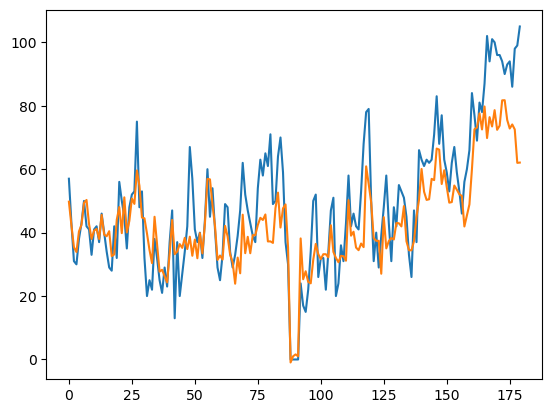

In [33]:
# 可視化
plt.plot(predicted_df)

In [34]:
pred_submit = gbm.predict(test_data)
submit = pd.DataFrame({'date' : test_data.index, 'pred' : pred_submit})
submit.reset_index(drop=True)
submit.columns = submit.iloc[0]
#submit.to_csv('signate_ligthGBM_1.csv', index=False)

In [35]:
submit

,2016-04-01 00:00:00,56.443357
0,2016-04-01,56.443357
1,2016-04-02,53.344024
2,2016-04-03,66.737240
3,2016-04-04,71.300183
4,2016-04-05,54.954329
...,...,...
360,2017-03-27,57.717378
361,2017-03-28,56.790406
362,2017-03-29,53.234638
363,2017-03-30,59.945748
